In [1]:
import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import resnet
from custom_datasets import CIFAR10C
from trainer import AverageMeter, model_names
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['resnet110', 'resnet1202', 'resnet20', 'resnet32', 'resnet44', 'resnet56']


In [2]:
model = torch.nn.DataParallel(resnet.__dict__['resnet20'](num_classes=11))

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [3]:
run_name = "rl_mc4_seed1"
checkpoint_name = "data/"+run_name+"/checkpoint.th"
model.cuda()

print("=> loading checkpoint '{}'".format(checkpoint_name))
checkpoint = torch.load(checkpoint_name)
model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint 'data/rl_mc4_seed1/checkpoint.th'


<All keys matched successfully>

In [4]:
network = model._modules.get('module')

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False,
    num_workers=4, pin_memory=True)

valc_loaders_all = []
for corruption_type in ["impulse_noise", "defocus_blur", "motion_blur", "shot_noise", "speckle_noise"]:
    valc_loaders = []
    for corruption_level in range(5):
        valc_loader = torch.utils.data.DataLoader(
            CIFAR10C(corruption_type, corruption_level, transform=transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])),
            batch_size=128, shuffle=False,
            num_workers=4, pin_memory=True)
        valc_loaders.append(valc_loader)
    valc_loaders_all.append(valc_loaders)

In [69]:
representations = np.zeros((0, 64))

for i, (input, target) in enumerate(val_loader):
    input = input.cuda()
    target = target.cuda()

    representation = network.get_representation2(input)
    representations = np.concatenate((representations, representation.cpu().detach().numpy()), axis=0)

In [73]:
outputs = network.linear(torch.from_numpy(representations).float().cuda())

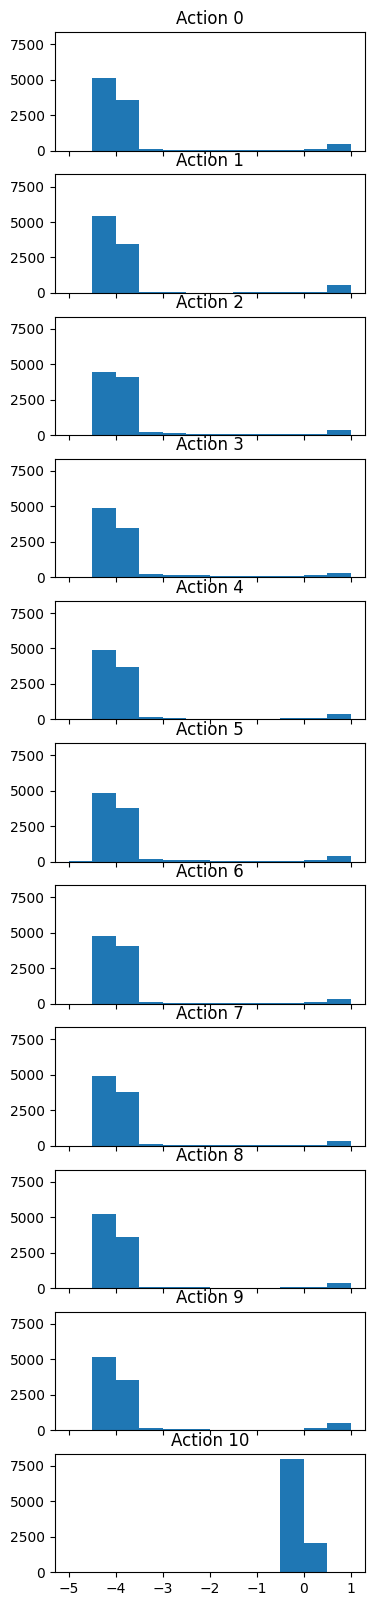

In [81]:
#make 11 subplots
fig, axs = plt.subplots(11, 1, figsize=(4, 20), sharex=True, sharey=True)
for i in range(11):
    axs[i].hist(outputs[:, i].cpu().detach().numpy(), [0.5*_ for _ in range(-10, 3)])
    axs[i].set_title("Action "+str(i))

In [82]:

pca = PCA(n_components=10)
pca.fit(representations)
projection_matrix =  np.dot(pca.components_.T, pca.components_)
data_mean = pca.mean_

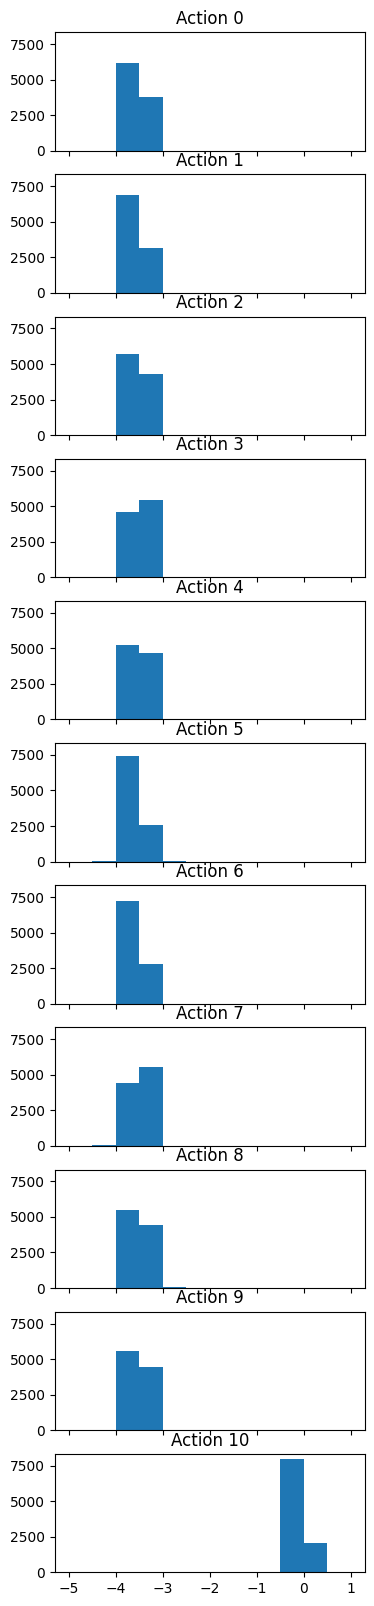

In [102]:
normalized_data = (representations - data_mean)
projected_data = np.dot(normalized_data, np.eye(64) - projection_matrix) + data_mean
outputs = network.linear(torch.from_numpy(projected_data).float().cuda())
fig, axs = plt.subplots(11, 1, figsize=(4, 20), sharex=True, sharey=True)
for i in range(11):
    axs[i].hist(outputs[:, i].cpu().detach().numpy(), [0.5*_ for _ in range(-10, 3)])
    axs[i].set_title("Action "+str(i))

In [161]:
outputs = network.linear(torch.from_numpy(data_mean).float().cuda())
outputs

tensor([-3.5229e+00, -3.5246e+00, -3.5120e+00, -3.4960e+00, -3.5003e+00,
        -3.5477e+00, -3.5294e+00, -3.4897e+00, -3.5072e+00, -3.5090e+00,
        -1.3390e-06], device='cuda:0', grad_fn=<AddBackward0>)

(-4.0, 1.0)

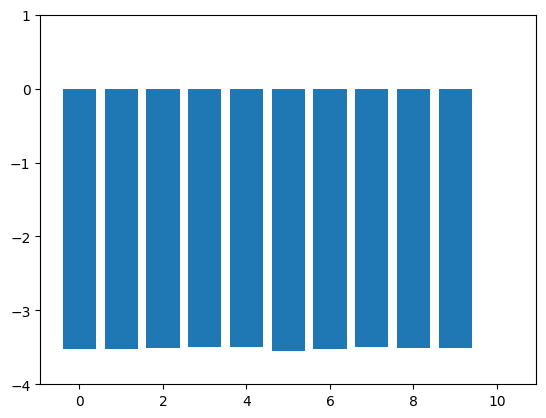

In [164]:
plt.bar(range(11), outputs.cpu().detach().numpy())
plt.ylim(-4, 1)

In [105]:
data_mean

array([0.12382347, 0.10676454, 0.12832256, 0.12173576, 0.10353488,
       0.05486134, 0.13244401, 0.12065359, 0.35416129, 0.43605261,
       0.52070788, 0.0400714 , 0.08945521, 0.06364362, 0.47293818,
       0.27343407, 0.52974808, 0.27836795, 0.26419203, 0.08070131,
       0.08199907, 0.14884838, 0.1249538 , 0.13440221, 0.24413167,
       0.16370009, 0.06307947, 0.15458208, 0.0852414 , 0.15466742,
       0.09179064, 0.04807517, 0.11578666, 0.1468474 , 0.13870137,
       0.18593637, 0.21655753, 0.17199505, 0.02454705, 0.17814274,
       0.10197915, 0.16485468, 0.12716328, 0.38861853, 0.08405264,
       0.09797927, 0.45151001, 0.02566535, 0.11198751, 0.12642934,
       0.12109326, 0.35558626, 0.11202743, 0.07344437, 0.65245098,
       0.12146401, 0.16146619, 0.27133958, 0.13631648, 0.41612032,
       0.16126305, 0.31720368, 0.0557493 , 0.08126102])

In [203]:
out = torch.zeros((1, 16, 32, 32)).cuda().float() #F.relu((network.bn1(network.conv1(input.cuda()))))

out = F.relu(network.bn1.bias.unsqueeze(0).unsqueeze(2).unsqueeze(3)+out)
out = network.layer1(out)
# out = torch.zeros(out.shape).cuda().float()
out = network.layer2(out)
# out = torch.zeros(out.shape).cuda().float()
out = network.layer3(out)
# out = torch.zeros(out.shape).cuda().float()
# out = network.layer3[2](torch.zeros(out.shape).cuda().float())
out = F.avg_pool2d(out, out.size()[3])
out = out.view(out.size(0), -1)
out_final1 = network.linear(out)
print(out_final1)

tensor([[-3.4820e+00, -3.4808e+00, -4.0971e+00, -3.5755e+00, -3.6089e+00,
         -3.8819e+00, -3.7967e+00, -3.4534e+00, -3.7080e+00, -3.1650e+00,
         -5.5646e-06]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [201]:
network.bn1.bias.unsqueeze(0).unsqueeze(2).unsqueeze(3)

tensor([[[[ 0.8583]],

         [[-0.0101]],

         [[-0.2875]],

         [[ 0.5197]],

         [[-0.9862]],

         [[ 0.5513]],

         [[-0.0977]],

         [[ 0.4060]],

         [[-0.0118]],

         [[-0.4916]],

         [[-0.2036]],

         [[ 0.5195]],

         [[ 1.4948]],

         [[-0.5694]],

         [[ 0.3538]],

         [[-0.0125]]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)

In [196]:
((representations- data_mean)**2).mean()

0.03162915786931459

In [181]:
out = torch.zeros((1, 16, 32, 32)).cuda().float() #F.relu((network.bn1(network.conv1(input.cuda()))))
out = network.layer1(out)
out = torch.zeros(out.shape).cuda().float()
out = network.layer2(out)
# out = torch.zeros(out.shape).cuda().float()
out = network.layer3(out)
# out = torch.zeros(out.shape).cuda().float()
# out = network.layer3[2](torch.zeros(out.shape).cuda().float())
out = F.avg_pool2d(out, out.size()[3])
out = out.view(out.size(0), -1)
out_final2 = network.linear(out)

In [182]:
out = torch.zeros((1, 16, 32, 32)).cuda().float() #F.relu((network.bn1(network.conv1(input.cuda()))))
out = network.layer1(out)
# out = torch.zeros(out.shape).cuda().float()
out = network.layer2(out)
out = torch.zeros(out.shape).cuda().float()
out = network.layer3(out)
# out = torch.zeros(out.shape).cuda().float()
# out = network.layer3[2](torch.zeros(out.shape).cuda().float())
out = F.avg_pool2d(out, out.size()[3])
out = out.view(out.size(0), -1)
out_final3 = network.linear(out)

In [184]:
out = torch.zeros((1, 16, 32, 32)).cuda().float() #F.relu((network.bn1(network.conv1(input.cuda()))))
out = network.layer1(out)
# out = torch.zeros(out.shape).cuda().float()
out = network.layer2(out)
# out = torch.zeros(out.shape).cuda().float()
out = network.layer3(out)
# out = torch.zeros(out.shape).cuda().float()
out = network.layer3[2](torch.zeros(out.shape).cuda().float())
out = F.avg_pool2d(out, out.size()[3])
out = out.view(out.size(0), -1)
out_final4 = network.linear(out)

In [185]:
out = torch.zeros((1, 16, 32, 32)).cuda().float() #F.relu((network.bn1(network.conv1(input.cuda()))))
out = network.layer1(out)
# out = torch.zeros(out.shape).cuda().float()
out = network.layer2(out)
# out = torch.zeros(out.shape).cuda().float()
out = network.layer3(out)
out = torch.zeros(out.shape).cuda().float()
# out = network.layer3[2](torch.zeros(out.shape).cuda().float())
out = F.avg_pool2d(out, out.size()[3])
out = out.view(out.size(0), -1)
out_final5 = network.linear(out)

Text(0, 0.5, 'Output')

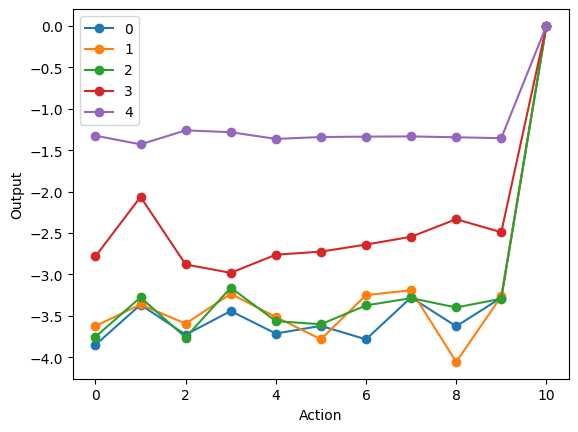

In [190]:
out_finals = [out_final1, out_final2, out_final3, out_final4, out_final5]
for i in range(5):
    plt.plot(out_finals[i].cpu().detach().numpy()[0], "o-", label=str(i))
plt.legend()
plt.xlabel("Action")
plt.ylabel("Output")

In [115]:
# out-data_mean

# norm = torch.norm(out.detach().cpu().numpy()-data_mean, dim=1)

np.linalg.norm(out.detach().cpu().numpy()-data_mean, axis=-1)

array([0.59795821])

In [116]:
outputs = network.linear(out)
print(outputs)

tensor([[-3.8499e+00, -3.3641e+00, -3.7266e+00, -3.4410e+00, -3.7126e+00,
         -3.6198e+00, -3.7827e+00, -3.2769e+00, -3.6255e+00, -3.2802e+00,
          1.7392e-06]], device='cuda:0', grad_fn=<AddmmBackward0>)


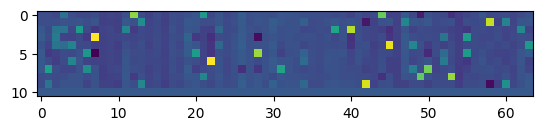

In [100]:

plt.imshow(network.linear._parameters["weight"].detach().cpu().numpy())

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(representations)
projection_matrix =  np.dot(pca.components_.T, pca.components_)
data_mean = pca.mean_


In [42]:
normalized_data = (representations - data_mean)

projected_data = np.dot(normalized_data, np.eye(64) - projection_matrix)

In [59]:
bias = network.linear._parameters["bias"]
# pred_distributions = F.softmax(bias).cpu().detach().numpy()
# entropies = -np.sum(pred_distributions*np.log(pred_distributions))
# print(entropies)

(-4.0, 1.0)

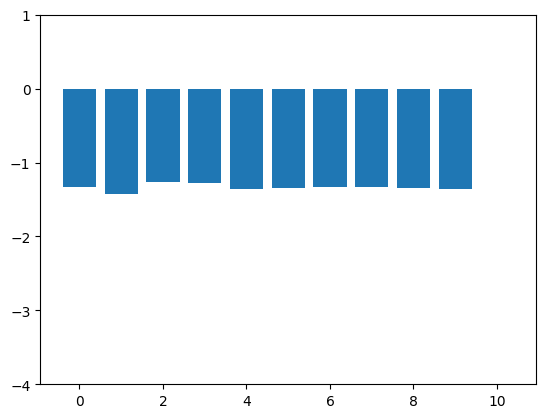

In [62]:

plt.bar(np.arange(11), bias.cpu().detach().numpy())
plt.ylim(-4, 1)

In [63]:
-4*0.9+1*0.1

-3.5

In [53]:
pred_distributions

array([0.10663579, 0.0725323 , 0.11843599, 0.13975897, 0.13087583,
       0.07051046, 0.11430451, 0.07727335, 0.0886979 , 0.08097491],
      dtype=float32)

(0.0, 1.0)

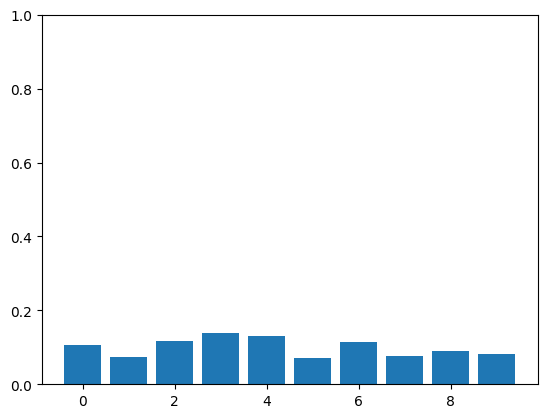

In [52]:
plt.bar(np.arange(10), pred_distributions)
plt.ylim(0, 1)

In [50]:
bias

Parameter containing:
tensor([ 0.0925, -0.2929,  0.1975,  0.3630,  0.2974, -0.3211,  0.1620, -0.2295,
        -0.0917, -0.1827], device='cuda:0', requires_grad=True)

In [47]:
Wx_output = network.linear(torch.from_numpy(projected_data+data_mean).float().cuda())-network.linear._parameters["bias"]#.cpu().detach().numpy()

In [48]:
Wx_output.median(axis=0)[0]+network.linear._parameters["bias"]

tensor([-0.0326,  0.1255,  0.3064,  1.2995, -0.4062,  0.2080, -1.0130, -0.2258,
        -0.8500,  0.5875], device='cuda:0', grad_fn=<AddBackward0>)

In [32]:
-10*(1/10*np.log(1/10))

2.3025850929940455

In [45]:
pred_distributions = F.softmax(Wx_output, dim=1).cpu().detach().numpy()
entropies = -np.sum(pred_distributions*np.log(pred_distributions), axis=1)

(array([3.000e+00, 1.300e+01, 5.800e+01, 2.200e+02, 7.300e+02, 1.797e+03,
        3.176e+03, 3.121e+03, 8.310e+02, 5.100e+01]),
 array([1.7069992, 1.761027 , 1.8150547, 1.8690825, 1.9231102, 1.977138 ,
        2.0311658, 2.0851934, 2.1392212, 2.193249 , 2.2472768],
       dtype=float32),
 <BarContainer object of 10 artists>)

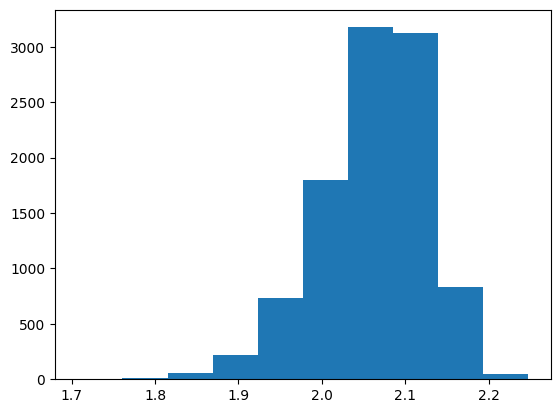

In [46]:
plt.hist(entropies)

In [9]:


def get_avg_num_zeros(network, input):
    out = F.relu((network.bn1(network.conv1(input.cuda()))))
    avg_num_zeros0 = (out == 0).sum().item() / (out.shape[0] * out.shape[1] * out.shape[2] * out.shape[3])
    out = network.layer1(out)
    avg_num_zeros1 = (out == 0).sum().item() / (out.shape[0] * out.shape[1] * out.shape[2] * out.shape[3])
    out = network.layer2(out)
    avg_num_zeros2 = (out == 0).sum().item() / (out.shape[0] * out.shape[1] * out.shape[2] * out.shape[3])
    out = network.layer3(out)
    avg_num_zeros3 = (out == 0).sum().item() / (out.shape[0] * out.shape[1] * out.shape[2] * out.shape[3])
    out = F.avg_pool2d(out, out.size()[3])
    out = out.view(out.size(0), -1)
    out = network.linear(out)
    out = torch.nn.functional.softmax(out, dim=1)
    avg_entropy = -torch.sum(out * torch.log(out), dim=1).mean().item()
    return avg_num_zeros0, avg_num_zeros1, avg_num_zeros2, avg_num_zeros3, avg_entropy

In [10]:
get_avg_num_zeros(network, next(iter(val_loader))[0])

(0.3678855895996094,
 0.13873863220214844,
 0.3951902389526367,
 0.5557384490966797,
 0.1592850387096405)

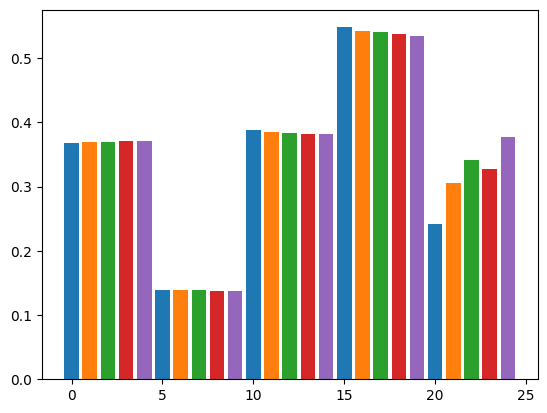

In [23]:
import matplotlib.pyplot as plt
for corruption_idx in range(5):
    data = get_avg_num_zeros(network, next(iter(valc_loaders_all[4][corruption_idx]))[0])
    plt.bar([_*5+corruption_idx for _ in range(5)], list(data))

In [33]:
out = F.relu(network.bn1(zero_input))


In [48]:
out = F.relu((zero_input))
out = network.layer1(out)
out = network.layer2(out)
out = network.layer3(out)
out = F.avg_pool2d(out, out.size()[3])
out = out.view(out.size(0), -1)
out.shape

torch.Size([128, 64])

In [49]:
out = network.linear(torch.zeros([128, 64]).cuda())
out = torch.nn.functional.softmax(out, dim=1)
out[0]

tensor([0.1066, 0.0725, 0.1184, 0.1398, 0.1309, 0.0705, 0.1143, 0.0773, 0.0887,
        0.0810], device='cuda:0', grad_fn=<SelectBackward0>)

In [58]:
out = network.linear._parameters["bias"]
out = torch.nn.functional.softmax(out)
out

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor([0.1066, 0.0725, 0.1184, 0.1398, 0.1309, 0.0705, 0.1143, 0.0773, 0.0887,
        0.0810], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
# get mean representation for each corruption level
# get difference between mean representations for each corruption level
# see if directions lie in a line (?)
# see which directions extrapolate
# see if trend holds for all corruption types

In [11]:
norms_all = np.zeros((0))
output_entropies_all = np.zeros((0))

for i, (input, target) in enumerate(val_loader):
    input = input.cuda()
    target = target.cuda()

    out = F.relu((network.bn1(network.conv1(input.cuda()))))
    
    out = network.layer1(out)
    out1_norms = ((out-network.layer1[2].bn2.bias.unsqueeze(0).unsqueeze(2).unsqueeze(3)**2).sum(dim = [1, 2, 3])).sqrt()
    
    out = network.layer2(out)
    

    
    out = network.layer3(out)
    
    
    out = F.avg_pool2d(out, out.size()[3])
    out = out.view(out.size(0), -1)
    out_final1 = network.linear(out)
    out_final1 = torch.nn.functional.softmax(out_final1, dim=1)
    out_final1 = out_final1.cpu().detach().numpy()
    output_entropies_all = np.concatenate((output_entropies_all, -np.sum(out_final1*np.log(out_final1), axis=1)), axis=0)
    # print(out_final1)
    # accuracy = np.mean(out_final1.argmax(axis=1)==target.cpu().detach().numpy())
    # print(accuracy)
    # print(out_final1.argmax(axis=1)==target.cpu().detach().numpy())

    norms_all = np.concatenate((norms_all, out1_norms.cpu().detach().numpy()), axis=0)

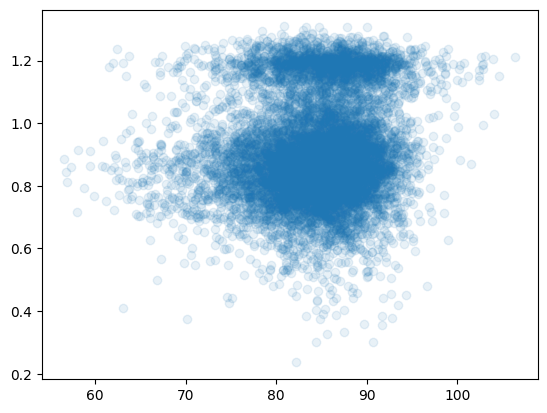

In [12]:
plt.scatter(norms_all, output_entropies_all, alpha=0.1)

In [10]:
network.layer1[2].bn2.bias.shape

torch.Size([16])

In [240]:
norms_all_4 = np.zeros((0))

for i, (input, target) in enumerate(valc_loaders_all[0][4]):
    input = input.cuda()
    target = target.cuda()

    out = F.relu((network.bn1(network.conv1(input.cuda()))))
    out = network.layer1(out)
    out = network.layer2(out)
    
    out = network.layer3(out)
    
    out = F.avg_pool2d(out, out.size()[3])
    out = out.view(out.size(0), -1)
    out_final1 = network.linear(out)
    out1_norms = ((out**2).sum(dim = [1])).sqrt()
    # print(out_final1)

    norms_all_4 = np.concatenate((norms_all_4, out1_norms.cpu().detach().numpy()), axis=0)

(array([2.048e+03, 3.270e+03, 2.996e+03, 1.385e+03, 2.260e+02, 4.800e+01,
        1.700e+01, 8.000e+00, 1.000e+00, 1.000e+00]),
 array([1.79397142, 2.01030225, 2.22663307, 2.4429639 , 2.65929472,
        2.87562555, 3.09195638, 3.3082872 , 3.52461803, 3.74094886,
        3.95727968]),
 <BarContainer object of 10 artists>)

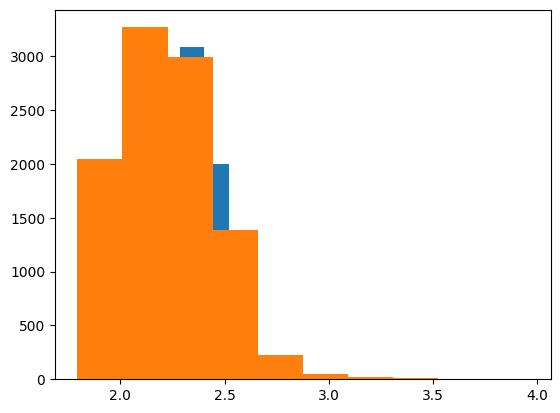

In [241]:
plt.hist(norms_all)
plt.hist(norms_all_4)

In [242]:
norms_all_4.mean()

2.2204323416233063

In [243]:
norms_all.mean()

2.30930983505249